In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os

class DogCaptionDataset(Dataset):
    def __init__(self, csv_file, processor):
        self.data = pd.read_csv(csv_file)
        self.processor = processor
        self.image_dir = '/content/project/dogs'  # Or full correct absolute path to images

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        img_filename = row['image_path']  # Column name in your CSV
        caption = row['caption']

        # Construct full correct path
        img_path = os.path.join(self.image_dir, os.path.basename(img_filename))

        # Load and preprocess image
        image = Image.open(img_path).convert("RGB")

        # Preprocess for BLIP2
        inputs = self.processor(images=image, text=caption, return_tensors="pt", padding="max_length", max_length=128)

        # Squeeze batch dim
        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": inputs["input_ids"].squeeze(0),  # BLIP uses input_ids as labels for captioning
        }


In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

# === Step 1: Model, Processor, Dataset Setup ===

model_name = "Salesforce/blip-flan-t5-xl"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load dataset
dataset = DogCaptionDataset("project/dog_desc.csv", processor)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# === Step 2: Optimizer and Training Loop ===

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 3

model.train()

for epoch in range(num_epochs):
    total_loss = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}"):
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}")

# === Step 3: Save the Model ===

model.save_pretrained("./blip_dog_caption_model")
processor.save_pretrained("./blip_dog_caption_model")


Epoch 1: 100%|██████████| 101/101 [00:52<00:00,  1.94it/s]


Epoch 1 completed. Average Loss: 3.4339


Epoch 2: 100%|██████████| 101/101 [00:46<00:00,  2.17it/s]


Epoch 2 completed. Average Loss: 0.7264


Epoch 3: 100%|██████████| 101/101 [00:46<00:00,  2.18it/s]


Epoch 3 completed. Average Loss: 0.5024


[]

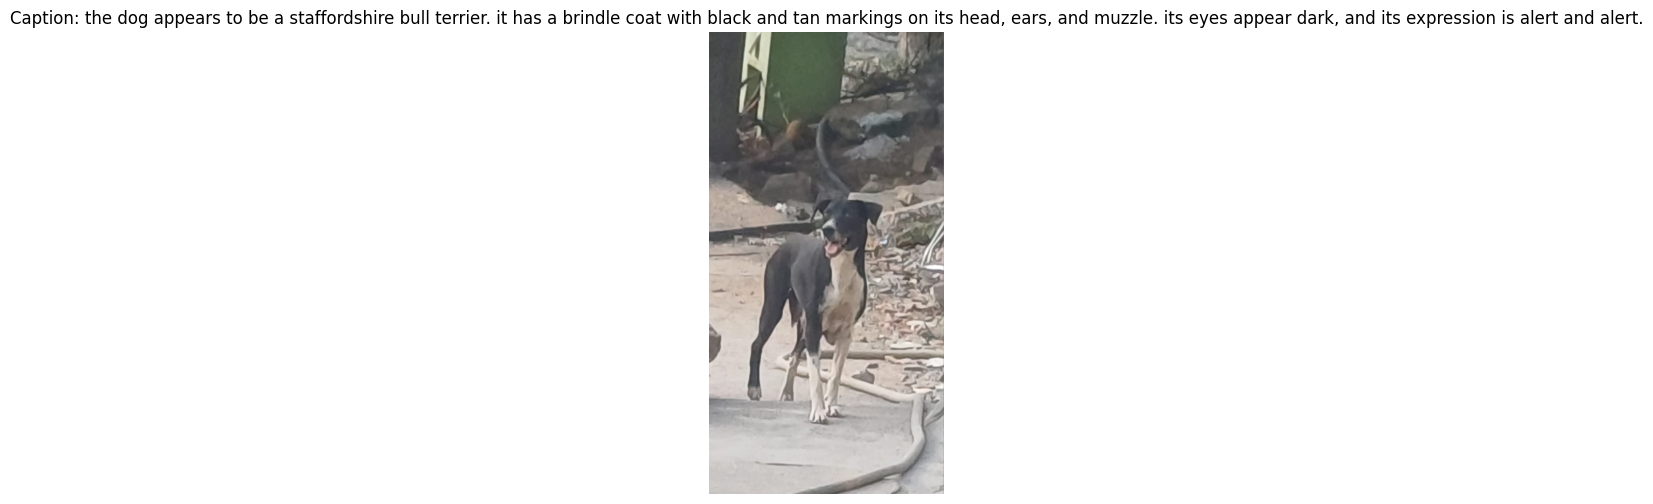

In [ ]:
import matplotlib.pyplot as plt
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained model
processor = BlipProcessor.from_pretrained("./blip_dog_caption_model")
model = BlipForConditionalGeneration.from_pretrained("./blip_dog_caption_model").to(device)

# Load an image
image_path = "tests/test6.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Preprocess the image
inputs = processor(images=image, return_tensors="pt").to(device)

# Generate caption
model.eval()
with torch.no_grad():
    output = model.generate(**inputs, max_length=100, num_beams=5)

# Decode the caption
caption = processor.decode(output[0], skip_special_tokens=True)

# Show the image and caption with Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Caption: {caption}", fontsize=12, color="black")
plt.show()

In [ ]:
import shutil

# Path to the folder you want to zip
folder_path = "/content/blip_dog_caption_model"

# Output zip file path
output_zip = "/content/blip_dog_caption_model.zip"

# Create zip archive
shutil.make_archive(base_name=output_zip.replace(".zip", ""), format="zip", root_dir=folder_path)

print(f"Folder zipped successfully at: {output_zip}")


Folder zipped successfully at: /content/blip_dog_caption_model.zip
